In [1]:
import os
path1 = '/kaggle/working/Checkpoints'
path2 = '/kaggle/working/Checkpoints/loss'
path3 = '/kaggle/working/Checkpoints/images'

# Create the folder if it doesn't exist
if not os.path.exists(path1):
    os.makedirs(path1)
    print("Folder 'Checkpoints' created successfully.")
else:
    print("Folder 'Checkpoints' already exists.")
    
if not os.path.exists(path2):
    os.makedirs(path2)
    print("Folder 'loss' created successfully.")
else:
    print("Folder 'loss' already exists.")
    
if not os.path.exists(path3):
    os.makedirs(path3)
    print("Folder 'images' created successfully.")
else:
    print("Folder 'images' already exists.")

Folder 'Checkpoints' created successfully.
Folder 'loss' created successfully.
Folder 'images' created successfully.


In [2]:
#Importing the dependencies
import os
import sys
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import binary_crossentropy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_sketch_dir = "/kaggle/input/artigen-vae"
# valid_sketch_dir = "/kaggle/input/sketch/Sketch/val"
batch_size = 80
sketch_size = 256
latent_dim=3


In [4]:
print("for training and validation")
dataset = tf.keras.utils.image_dataset_from_directory(
    train_sketch_dir,
    shuffle=True,
    validation_split=0.2,  # Split 20% for validation
    subset="training",
    seed=42,
    color_mode='grayscale',
    image_size=(256, 256),
    batch_size=80
)

# Normalization layer [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Function to normalize the pixel values
def preprocess(image, label):
    # Normalize the pixel values to the range [0, 1]
    image = normalization_layer(image)

    return image, label

# Apply normalization to both training and validation datasets
dataset = dataset.map(preprocess)

# Separate the dataset into training and validation sets
train_dataset = dataset.take(int(0.8 * len(dataset)))
val_dataset = dataset.skip(int(0.8 * len(dataset)))


for training and validation
Found 14027 files belonging to 14 classes.
Using 11222 files for training.


In [5]:
# train_ds

In [6]:
# test_ds

In [7]:
# Define the sampling layer
class Sampling(layers.Layer):
    # Uses (z_mean, z_log_var) to sample z, the vector encoding the sketch.
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
latent_dim = 3  # Updated latent dimension
encoder_dropout = 0.5

# Encoder network
encoder_inputs = keras.Input(shape=(sketch_size, sketch_size, 1))  # Input shape (256, 256, 1)

x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(encoder_dropout)(x)  

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dense(64, activation="relu", activity_regularizer=keras.regularizers.l1(0.01))(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [9]:
latent_dim = 3  # Updated latent dimension

# Decoder network
latent_inputs = keras.Input(shape=(latent_dim,))  # Input shape (3,)

x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128 * (sketch_size // 8) * (sketch_size // 8), activation="relu")(x)  # Assuming stride 2 in encoder

x = layers.Reshape((sketch_size // 8, sketch_size // 8, 128))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # Output shape (256, 256, 1)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 128)               512       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      147584    
 nspose)                                                         
                                                           

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.train_loss_tracker = keras.metrics.Mean(name="train_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.valid_loss_tracker = keras.metrics.Mean(name="valid_loss")
        self.latent_dim = latent_dim  # Updated latent dimension

    @property
    def metrics(self):
        return [
            self.train_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.valid_loss_tracker,
        ]

    def train_step(self, data):
        input_sketch, _ = data  # Unpack the training data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(input_sketch)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(input_sketch, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            train_loss = reconstruction_loss + kl_loss

        gradients = tape.gradient(train_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.train_loss_tracker.update_state(train_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "train_loss": self.train_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        valid_sketch, _ = data  # Unpack the validation data
        _, _, z = self.encoder(valid_sketch)
        reconstruction = self.decoder(z)
        valid_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(valid_sketch, reconstruction),
                axis=(1, 2),
            )
        )
        self.valid_loss_tracker.update_state(valid_loss)
        return {"valid_loss": self.valid_loss_tracker.result()}


In [11]:
for(image, _) in val_dataset.take(1):
    random_sketch = image[:5]

In [12]:
class ModelMonitor(Callback):
    def __init__(self, encoder, decoder, weight_dir, latent_dim, random_sketch):
        self.encoder = encoder
        self.decoder = decoder
        self.weight_dir = weight_dir
        self.latent_dim = latent_dim
        self.random_sketch = random_sketch

        self.train_loss = []
        self.reconstruction_loss = []
        self.kl_loss = []
        self.valid_loss = []
        self.epoch_counter = 0

    def on_epoch_end(self, epoch, logs=None):
        self.train_loss.append(logs.get('train_loss'))
        self.reconstruction_loss.append(logs.get('reconstruction_loss'))
        self.kl_loss.append(logs.get('kl_loss'))
        self.valid_loss.append(logs.get('valid_loss'))  # Update to valid_loss

        if (epoch + 1) % 10 == 0:
            self.epoch_counter += 1

            # Save encoder and decoder weights
            encoder_filename = os.path.join(self.weight_dir, f'encoder_epoch_{epoch+10}.h5')
            decoder_filename = os.path.join(self.weight_dir, f'decoder_epoch_{epoch+10}.h5')
            self.encoder.save_weights(encoder_filename)
            self.decoder.save_weights(decoder_filename)

            # Construct and visualize 5 pairs of images
            self.visualize_images(self.random_sketch, epoch)

            # Save the loss values
            loss_file = os.path.join(self.weight_dir, 'loss', f'losses_epoch_{epoch + 10}.pkl')
            with open(loss_file, 'wb') as f:
                pickle.dump({'train_loss': self.train_loss, 'reconstruction_loss': self.reconstruction_loss,
                             'kl_loss': self.kl_loss, 'valid_loss': self.valid_loss}, f)

    def visualize_images(self, sketch, epoch):
        fig, axes = plt.subplots(2, 5, figsize=(8, 8))
        
        # Encode the sketches
        _, _, z = self.encoder(sketch)
        
        # Decode the sketches
        reconstructed_sketch = self.decoder(z)

        # Plot the actual sketch in the first row
        for i in range(5):
            axes[0, i].imshow(sketch[i].numpy().reshape(256, 256), cmap='gray')
            axes[0, i].axis('off')
        axes[0, 2].set_title('Actual Sketches', fontsize=14)

        # Plot the constructed sketch images in the second row
        for i in range(5):
            axes[1, i].imshow(reconstructed_sketch[i].numpy().reshape(256, 256), cmap='gray')
            axes[1, i].axis('off')
        axes[1, 2].set_title('Constructed Sketches', fontsize=14)

        plt.tight_layout()

        # Save the figure
        fig_filename = os.path.join(self.weight_dir, 'images', f'sketch_epoch_{epoch + 10}.png')
        plt.savefig(fig_filename)
        plt.close()


In [13]:
weight_dir = '/kaggle/working/Checkpoints/'  # Corrected variable name

learning_rate = 0.00014741303738729527

model_monitor = ModelMonitor(encoder, decoder, weight_dir, latent_dim, random_sketch)
vae = VAE(encoder, decoder, latent_dim)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)  # Removed 'loss' argument since it's already defined in the VAE class



In [14]:
output = vae.fit(train_dataset, validation_data=val_dataset, epochs=300, callbacks=[model_monitor])

Epoch 1/300
112/112 [==============================] - 75s 515ms/step - train_loss: 19168.3613 - reconstruction_loss: 18527.8789 - kl_loss: 640.4855 - val_valid_loss: 11949.3379
Epoch 2/300
112/112 [==============================] - 58s 517ms/step - train_loss: 11909.9590 - reconstruction_loss: 11875.4785 - kl_loss: 34.4822 - val_valid_loss: 11774.1846
Epoch 3/300
112/112 [==============================] - 58s 518ms/step - train_loss: 11558.2695 - reconstruction_loss: 11536.0029 - kl_loss: 22.2662 - val_valid_loss: 12543.9775
Epoch 4/300
112/112 [==============================] - 58s 513ms/step - train_loss: 11412.4951 - reconstruction_loss: 11393.5938 - kl_loss: 18.9050 - val_valid_loss: 11083.2363
Epoch 5/300
112/112 [==============================] - 58s 513ms/step - train_loss: 11187.0508 - reconstruction_loss: 11170.4150 - kl_loss: 16.6338 - val_valid_loss: 11082.2607
Epoch 6/300
112/112 [==============================] - 58s 512ms/step - train_loss: 11143.6855 - reconstruction_lo

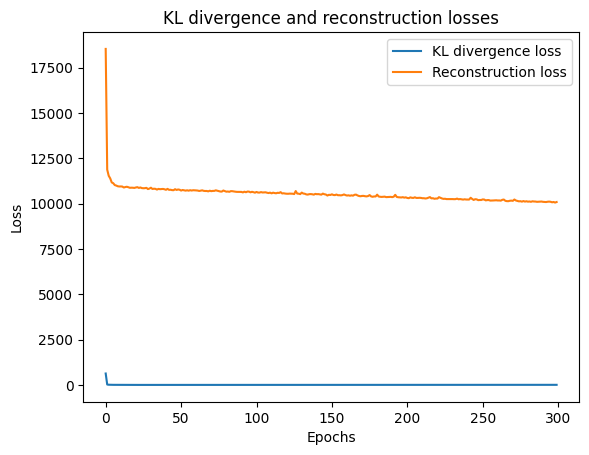

In [15]:
# Plot the reconstruction and kl divergence loss
plt.plot(output.history["kl_loss"], label="KL divergence loss")
plt.plot(output.history["reconstruction_loss"], label="Reconstruction loss")
plt.title('KL divergence and reconstruction losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an image
plt.savefig('train_losses.png')
plt.show()

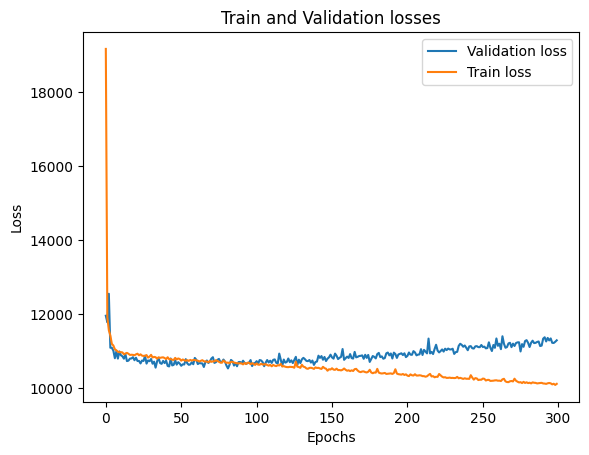

In [16]:
# Plot the reconstruction and kl divergence loss
plt.plot(output.history["val_valid_loss"], label="Validation loss")
plt.plot(output.history["train_loss"], label="Train loss")
plt.title('Train and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an image
plt.savefig('train_validation_losses.png')

# Show the plot
plt.show()


In [17]:
!zip -r test_image.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Checkpoints/ (stored 0%)
  adding: kaggle/working/Checkpoints/encoder_epoch_179.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/encoder_epoch_229.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/encoder_epoch_149.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/decoder_epoch_149.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/encoder_epoch_19.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/decoder_epoch_259.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/encoder_epoch_199.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/decoder_epoch_269.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/decoder_epoch_279.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/decoder_epoch_209.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/decoder_epoch_179.h5 (deflated 7%)
  adding: kaggle/working/Checkpoints/encoder_epoch_109.h5 (deflated 8%)
  adding: kaggle/working/Checkpoints/encoder_epoc

In [18]:
from IPython.display import FileLink
FileLink(r'test_image.zip')

/kaggle/working/test_image.zip

In [19]:
import shutil
import os
from IPython.display import HTML, display, Javascript

# Directory to be zipped
directory_to_zip = '/kaggle/working'
# Zip file name
zip_file_name = 'test_image.zip'

# Create the zip file
shutil.make_archive(zip_file_name.split('.')[0], 'zip', directory_to_zip)

# Display HTML with JavaScript to trigger automatic download after cell execution
display(HTML(f'<a id="download_link" href="{zip_file_name}" download="{zip_file_name}">Click here to download the zip file</a>'))
display(Javascript("document.getElementById('download_link').click();"))

<IPython.core.display.Javascript object>

In [20]:
# # For further training

# from tensorflow.keras.models import load_model
# encoder.load_weights('/kaggle/working/Checkpoints/encoder_epoch_109.h5')
# decoder.load_weights('/kaggle/working/Checkpoints/decoder_epoch_109.h5')

# # Compile the model
# vae.compile(optimizer='adam', loss='train_loss', metrics=['accuracy'])


# # Fit the model
# initial_epochs = 100
# additional_epochs = 150

# output = vae.fit(
#    train_ds,
#     validation_data=validation_ds,
#     epochs=initial_epochs + additional_epochs,
#     initial_epoch=initial_epochs,
#     callbacks=[model_monitor]
# )

In [21]:
# # For further training

# from tensorflow.keras.models import load_model
# encoder.load_weights('/kaggle/working/Checkpoints/encoder_epoch_179.h5')
# decoder.load_weights('/kaggle/working/Checkpoints/decoder_epoch_179.h5')

# # Compile the model
# vae.compile(optimizer='adam', loss='train_loss', metrics=['accuracy'])


# # Fit the model
# initial_epochs = 170
# additional_epochs = 230

# output = vae.fit(
#    train_ds,
#     validation_data=validation_ds,
#     epochs=initial_epochs + additional_epochs,
#     initial_epoch=initial_epochs,
#     callbacks=[model_monitor]
# )